# 1. Introduction

In [23]:
import os
os.chdir("C://Users/Think/Desktop/case")

One of my favourite maching learning models is boosting tree model. In boosting method, (in our case) we train different regression trees and the current tree is informed about which examples the previous tree got wrong. At the end of training, each tree votes on how each example should be predicted. A popular algorithm to implement this model is **xgboost**.

For supervised learning approaches, usually there are training and testing datasets that have the same structure. However, in our case we only have one time-series data set and we need to derive future values for the very same group of people. Thus we need to be more creative to turn this problem into a supervised learning problem.

My design is that we turn this problem into: **Given the customer features and the RFM numbers that are calulated for the past period (2016/9/1--our final observation date), what will the total revenue generated by this customer in the next 3 months be?** I turn this problem into a more general one. The model we build can actually predict the future 3 months' sales given any length of past period (9months, 8 months... etc). I plan to ignore the time series relevant features (seasonality, sequence etc) and turn the **dynamic** problem (predict future based on the past) into a **static** one (predict numbers based on *static* features).

The reason why I use this design is that I found out that for boosting tree model, it's not very appropriate to use the time series data directly as predictors (e.g. input the sales in the past 8 months as 8 predictors). Among our predictors, customer features in the **customer_info** stay unchanged over time. For the RFM features, we will leave average transaction value(M) as how they are and process the frequency(F) and recency(R) by dividing them by the length of the calibration period. Thus, the RFM features won't be affect much by the length of the calibration period but can also show *time-related information* (e.g. For someone with very low frequency and recency, if our calibration period is only 3 months then maybe he/she would turn alive later. If another 3 months have passed and his/her frequency and recency remain unchanged, since the calibration period is longer, his/her adjusted F and R value will be smaller, showing that he/she has fewer chance to turn alive).

Another reason is that I want to generate some "fake" data. Since in this case study, we don't have the "traditional" trainset and testset, we need to create them by ourself. Thus we already "break the rule". An obvious way to seperate the data into trainset and testset is to use the data from March 2017 to May 2017 as target variable (y), which means when we train the model, we will use the information from September 2016 to April 2017 to predict the total sales from March 2017 to May 2017. If we don't restrict the "new" calibration period as 6 months,we can create many more trainsets by shifting the "new holdout period" along the timeline. To better explain our design, I create some graphs to visulize how we will create our trainset and testset for our model.

<img src="train1.png">
<img src="train2.png">
<img src="train3.png">
<img src="test.png">

The pictures above show how I created our trainsets and testsets. Combining the 3 trainsets, we get a new trainsets with 60000 data points. In this way we can improve the robustness of our model and avoid overfitting. We will demonstrate later that our *adjusted* RFM features are consistent over different calibration period. There are other ways to create fake trainsets as well. For example we can move our *90-days holdout window* along the timeline measured by days. However, our data is quite sparse (many 0s) and I think it won't help much by creating too many "fake" data. 

An overview of our predictors:

- 7 features in the **customer_info** table
- Frequency and recency numbers in the corresponding calibration period divided by the length of the calibration period (number of days)
- Log average transaction value in the corresponding calibration period (avg_value)
- the length of the calibration period (I include this variable to show more time-related information) (cal_period)

Our target variable:

- Log total revenue in the holdout period (3 months long)

For this model, we did most of our job in R. So this notebook is basically a summary of our process.

# 2. Data and model

I will do data cleaning in R. The details can be checked in *ZODIAC case study [2.1] -- data preparation for xgboost.html* or *ZODIAC case study [2.1] -- data preparation for xgboost.Rmd*

Below is the very first RFM features caculation. I will feed the tables to the R markdown file mentioned above.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from lifetimes.utils import summary_data_from_transaction_data

In [11]:
customer_trans_log=pd.read_csv("customer_trans_log.csv")
log1=customer_trans_log.iloc[:,0:2].rename(columns={'customer_id':'id'})

In [12]:
time1=time.time()
summary1 = summary_data_from_transaction_data(log1, 'id', 'date', observation_period_end='2016-12-31')
time2=time.time()
diff=round(time2-time1)
print('took {} seconds'.format(diff))
print(summary1.head())

took 24 seconds
    frequency  recency      T
id                           
1         0.0      0.0  121.0
2        13.0    119.0  121.0
3         4.0    119.0  121.0
4         9.0    101.0  121.0
5         0.0      0.0  121.0


In [18]:
time1=time.time()
summary2 = summary_data_from_transaction_data(log1, 'id', 'date', observation_period_end='2017-1-31')
time2=time.time()
diff=round(time2-time1)
print('took {} seconds'.format(diff))
print(summary2.head())

took 26 seconds
    frequency  recency      T
id                           
1         0.0      0.0  152.0
2        18.0    146.0  152.0
3         6.0    142.0  152.0
4        15.0    144.0  152.0
5         0.0      0.0  152.0


In [20]:
time1=time.time()
summary3 = summary_data_from_transaction_data(log1, 'id', 'date', observation_period_end='2017-2-28')
time2=time.time()
diff=round(time2-time1)
print('took {} seconds'.format(diff))
print(summary3.head())

took 26 seconds
    frequency  recency      T
id                           
1         0.0      0.0  180.0
2        21.0    169.0  180.0
3         8.0    169.0  180.0
4        15.0    144.0  180.0
5         0.0      0.0  180.0


In [21]:
summary1.to_csv("rfm1.csv",index=False)
summary2.to_csv("rfm2.csv",index=False)
summary3.to_csv("rfm3.csv",index=False)

Let's load the data and have a look:

In [24]:
train=pd.read_csv("xgboost train.csv")
train.head()

,customer_id,First.Payment.Type,Age,Gender,Loyalty.Program,Acquisition.Channel,First.Department,Shared.Email,frequency,recency,cal_period,avg_value,y
0,1,3,3,2,1,5,6,2,0.000000,0.000000,121,4.139796,4.590361
1,2,1,2,1,2,2,4,2,0.107438,0.983471,121,3.331439,5.779354
2,3,4,3,1,2,3,6,2,0.033058,0.983471,121,3.295689,4.896720
3,4,1,3,1,2,2,4,2,0.074380,0.834711,121,3.822864,5.664279
4,5,1,4,1,1,4,6,2,0.000000,0.000000,121,2.937573,0.000000


In the R file, we plot the adjusted frequency and recency values for the different calibration periods and find out that they are not very different.Thus we have more confidence that our trained model can predict on the testing sets reasonably.

<img src="rfms.png">

I didn't make an Rmd file for parameter tuning process. But all the sample codes I used for training model and predicting can be found in *ZODIAC case study [2.2] -- xgboost.R*.

The parameters of our final model are:

- subsample:0.8
- learning rate:0.1
- max depth:8
- min child weight:5
- iteration: 5000

<img src="xgboost final.png">


In our parameter tuning process, the parameters above can achieve a validation rmse (of the log three-months sales amount ) of about 0.997 with 10000 rounds. However, we are worried about overfitting.Especailly in our case, we created many new training data from our original data and the characteristics of the testing data might be very different from that of the training data.Thus we predict twice with 5000 iterations and 10000 iterations seperately and compare the two results with the result we got from the Bayesian hierarchical model. In the end we decide to choose the iteration number 5000 since the result is closer to the one from Bayesian approach.

# 3. Result

## 3.1 Importance of the variables 

In [70]:
importance=pd.read_csv("xgboost importance matrix.csv")
height=[]
labels=[]
for i in range(len(importance)):
    height.append(round(importance['Gain'][i].item(),3))
    labels.append(importance['Feature'][i])

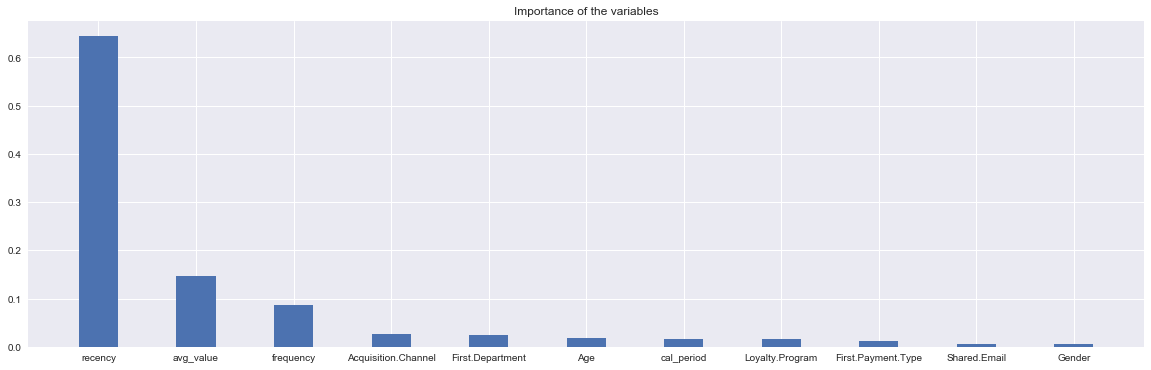

In [89]:
fig = plt.figure(1,figsize=(20, 6))  
ax  = fig.add_subplot(111)   
x=[]
for i in range(11):
    x.append(i*2)
ind = np.linspace(0,20,11) 
ax.bar(x,height)
ax.set_xticks(ind) 
ax.set_xticklabels(labels)
ax.set_title('Importance of the variables')
plt.show()

From the importance score plot above, we can see that the RFM features, especially recency, have great impact on our final result. Customer features such as acquisition channel and first department are also important, which resonates with our violinsplots in our first notebook.

## 3.2 Prediction

In [182]:
result_xgb=pd.read_csv("result_xgboost_5000_rounds.csv")
result_bys=pd.read_csv("result_bayesian.csv")
diff=np.array(result_xgb["three_month_pred"]-result_bys["three_month_pred"])

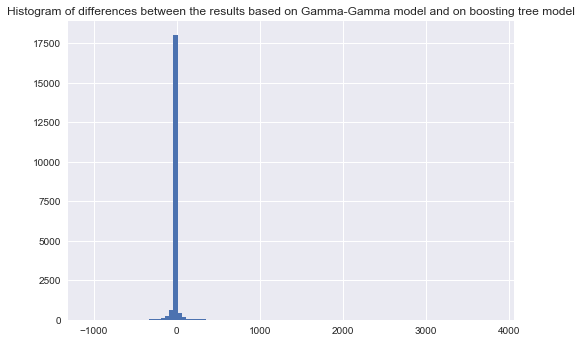

In [183]:
plt.hist(diff,bins=100)
plt.title('Histogram of differences between the results based on Gamma-Gamma model and on boosting tree model')
plt.show()

Quantiles of the differences:

In [186]:
print(np.percentile(diff,1))
print(np.percentile(diff,2.5))
print(np.percentile(diff,5))
print(np.percentile(diff,15))
print(np.percentile(diff,50))
print(np.percentile(diff,95))
print(np.percentile(diff,97))
print(np.percentile(diff,99))

-174.783124074
-93.6234827187
-48.3476519884
-9.02239123011
-1.52534809032
2.98414691911
28.1201363002
148.436579357


From the graph we might think the two results are quite consistent. However, that's becasue there are many inactive customers whose sales are close to 0. For those active customers, the results differentiate a lot. Observing and comparing the two results, we can see that boosting tree model can push the numbers to two extremes. The model in this notebook is more pessimistic towards inactive customers than Gamma-Gamma model, while it's more optimistic towards high value customers.When we train the model for more iterations, this characteristics becomes more evident and that's why we only run it for 5000 rounds. Recall that in our first notebook, we found out that the numbers predicted by Gamma-Gamma model are more moderate. So maybe it's a good idea to balance these two results.